# Tech-Challenge - Analysis
In this section you will be challenged with a couple of analytical questions about the data as well as some of the more technical nature regarding processing behind the scenes. There might be no single correct answer to some of the questions, feel free to provide solutions which make the most sense to you. 

In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import sqlite3

In [2]:
# Einlesen der csv-Files
path_to_files = 'data/'

df_account = pd.read_csv(path_to_files+'account.csv', sep=';')
df_card = pd.read_csv(path_to_files+'card.csv', sep=';')
df_client = pd.read_csv(path_to_files+'client.csv', sep=';')
df_disp = pd.read_csv(path_to_files+'disp.csv', sep=';')
df_district = pd.read_csv(path_to_files+'district.csv', sep=';')
df_loan = pd.read_csv(path_to_files+'loan.csv', sep=';')
df_order = pd.read_csv(path_to_files+'order.csv', sep=';')

df_trans =  pd.read_pickle(path_to_files+'trans_cleaned.pkl')

### Question 1
Look at some basic statistics of the data (mean, variance, etc.) of the “trans” table to understand it better. Print and explain an aspect of your choice (that you think is interesting) in the notebook.

In [3]:
df_trans.head()

,trans_id,account_id,date,type,operation,amount,balance,k_symbol,branch,bank,account,date_new
0,967842,1532,1998-05-31,PRJIEM,NaN,253,62661,UROK,AR,NaN,0,1998-05-31
1,271012,1499,1998-01-09,PRJIEM,VKLAD,5500,49790,NaN,AR,NaN,0,1998-01-09
2,971490,1645,1996-11-30,PRJIEM,NaN,43,19460,UROK,AR,NaN,0,1996-11-30
3,605699,3366,1996-10-28,VYDAJ,VYBER,9300,38433,NaN,AR,NaN,0,1996-10-28
4,443107,2471,1998-07-30,VYDAJ,VYBER,7800,56237,NaN,AR,NaN,0,1998-07-30


#### account_id, balance and amount
The three main number-features are: account_id, balance and amount. Statistical parameters like mean or standard deviation can be misleading, if you don't know, how the distribution looks like. I therefore like to visualize data with histograms to get a feeling for the data distribution, if there are multiple peaks and see if there are outliers.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f14481bb690>,
      dtype=object)

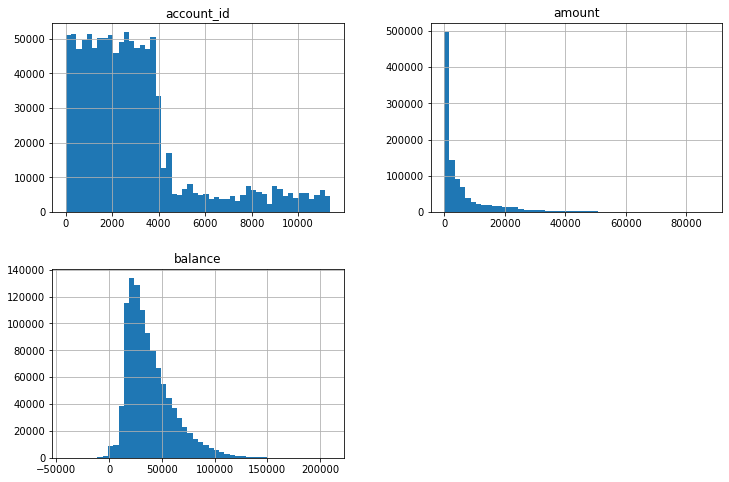

In [4]:
df_trans[['account_id','balance','amount']].hist(bins=50,figsize=(12,8))

- account_id: I expected the account_id to be evenly distributed, since account_id may not be an indicator for numbers of transactions. Or linearly decaying over time, since higher account_id could be an indicator of a newer account and newer accounts had "less time" to do transactions. But the number of transctions as a function of account_id is surprisingly a step function at account_id ~ 4000. I checked if "amount" or "balance" is different for account_id larger or smaller of 4000, but both have the same distribution

- amount: The distribution of "amount" is highly right skewed (for example 140000 transactions of 15). This is to be expected, so mean and standard deviation are not the most meaningful metric. Median and 0.25 and 0.75 quantile are more appropriate to grasp the spread of the distribution.

In [5]:
print('0.25 quantile is {}, median is {}, 0.75 quantile is {}'.format(df_trans.amount.quantile(0.25),df_trans.amount.quantile(0.5),df_trans.amount.quantile(0.75)))
print('The largest transaction is {} and the smallest {}'.format(df_trans.amount.max(), df_trans.amount.min()))

0.25 quantile is 136.0, median is 2100.0, 0.75 quantile is 6800.0
The largest transaction is 87400 and the smallest 0


- balance: Also balance is right skewed, although not as much as amount. But again, the more appropriate statistics are the quantiles.

In [6]:
print('0.25 quantile is {}, median is {}, 0.75 quantile is {}'.format(df_trans.balance.quantile(0.25),df_trans.balance.quantile(0.5),df_trans.balance.quantile(0.75)))
print('The largest amount is {} and the smallest {}'.format(df_trans.balance.max(), df_trans.balance.min()))

0.25 quantile is 22402.0, median is 33143.0, 0.75 quantile is 49603.25
The largest amount is 209637 and the smallest -41126


#### Date
Date is another interesting feature to look at. First, in the cleaning process I guessed that 0.1% of the dates may be wrong due to month-day switching, but this is such a small amount, that it does not worry us here. What we can do with dates is to see how many transactions were done during the recorded time period. Again, I use a histogram plot for each month.

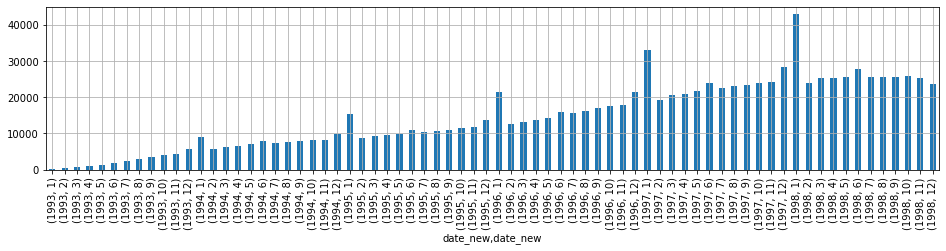

In [7]:
df_trans["date_new"].groupby([df_trans["date_new"].dt.year,df_trans["date_new"].dt.month]).count().plot(kind="bar",figsize=(16,3), grid = True)

It is interesting to see that number of transactions rises almost linearly until 1998 with an increase of about 5000 transactions each year and than has a plateau at about 260000 transactions for 1998. Also interesting are the increased number of transactions for every January. I do not see any further important statistical parameter for date.

### Question 2a
What district has the highest share of “withdrawal in cash”? Please use a SQL querie to get the required table.

In [9]:
# create a Database out of Dataframes
conn = sqlite3.connect('tech-challenge_db.db')
c = conn.cursor()

In [11]:
# create empty tables
c.execute('''CREATE TABLE account
             (account_id, district_id, frequency, date)''')
c.execute('''CREATE TABLE card
             (card_id, disp_id, type, issued)''')
c.execute('''CREATE TABLE client
             (client_id, gender, birth_date, district_id)''')
c.execute('''CREATE TABLE disp
             (disp_id, client_id, account_id, type)''')
c.execute('''CREATE TABLE district
             (district_id, A2, A3, A4, A5, A6, A7, A8, A9, A10,
       A11, A12, A13, A14, A15, A16)''')
c.execute('''CREATE TABLE loan
             (loan_id, account_id, date, amount, duration, payments,
       status)''')
c.execute('''CREATE TABLE order_table
             (order_id, account_id, bank_to, account_to, amount, k_symbol)''')
c.execute('''CREATE TABLE trans
             (trans_id, account_id, date, type, operation, amount,
       balance, k_symbol, branch, bank, account, date_new)''')
conn.commit()

In [10]:
# now fill the tables
df_account.to_sql('account', conn, if_exists='replace', index = False)
df_card.to_sql('card', conn, if_exists='replace', index = False)
df_client.to_sql('client', conn, if_exists='replace', index = False)
df_disp.to_sql('disp', conn, if_exists='replace', index = False)
df_district.to_sql('district', conn, if_exists='replace', index = False)
df_loan.to_sql('loan', conn, if_exists='replace', index = False)
df_order.to_sql('order_table', conn, if_exists='replace', index = False)
df_trans.to_sql('trans', conn, if_exists='replace', index = False)

Now lets go to the SQL querie to get the share of “withdrawal in cash”. Since I am not sure if share means the sum or the count of the amounts per district I calculate both. Nevertheless district #1 is the district with both the highest number of withdrawal in cash as well as the highest amount of money by withdrawal in cash.

In [11]:
df_summed_amount = pd.read_sql('''SELECT account.district_id AS district_id, 
            SUM(trans.amount) AS sum_amount, 
            COUNT(trans.amount) AS count_amount
            FROM trans
            LEFT JOIN account ON trans.account_id = account.account_id
            WHERE trans.operation == "VYBER"
            GROUP BY district_id
            ORDER BY sum_amount DESC''', conn)
df_summed_amount.head()

,district_id,sum_amount,count_amount
0,1,299565161,54701
1,70,79379766,14813
2,74,79044184,14256
3,64,58409160,9361
4,54,54498145,11482


### Question 2b
Please calculate the correlation between number of cash withdrawals per district and a number of inhabitants in particular district. Specify which correlation measure did you choose and describe the result.

So first I merge the dataframe, which I got from the SQL querie with the inhabitants of the district dataframe

In [12]:
# merge the dataframes
df_merged = df_summed_amount.merge(df_district, left_on='district_id', right_on='district_id')
# just keep the ones we need
df_merged = df_merged[['district_id','sum_amount','count_amount','A4']]
df_merged = df_merged.rename(columns={'count_amount': 'nr_withdrawals','A4': 'inhabitants'}) # rename
df_merged.head()

,district_id,sum_amount,nr_withdrawals,inhabitants
0,1,299565161,54701,1204953
1,70,79379766,14813,285387
2,74,79044184,14256,323870
3,64,58409160,9361,197099
4,54,54498145,11482,387570


For calculating the correlation between 'nr_withdrawals' and 'inhabitants' there are two main correlation factors

- Pearson correlation, which gives an answer how well the values of two variables are linearly related. For this to work the values should be normally distributed and the correlation is sensitive to outliers.
- Spearman rank correlation: Gives an answer how the ranks of values of two variables are linearly related. This correlation is more robust and insensitive to outliers. So lets see how the two values of the two variables 'nr_withdrawals' and 'inhabitants' are distributed.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f13f8087210>,
      dtype=object)

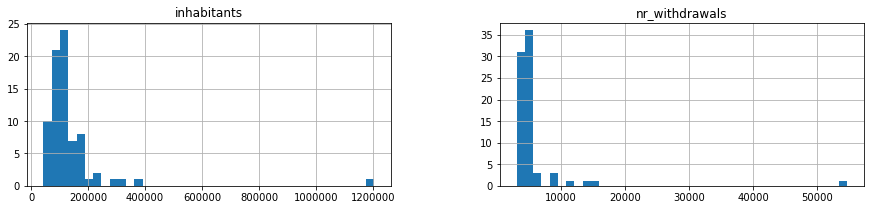

In [13]:
df_merged[['nr_withdrawals','inhabitants']].hist(bins=40,figsize=(15,3))

Both values have outliers, especially with the district of Prague, which has many more inhabitants than the other districts. If we print the number of withdrawals as a function of inhabitans one could argue there is a linear relationship and the Pearson correlation coefficient is very high with 0.96.

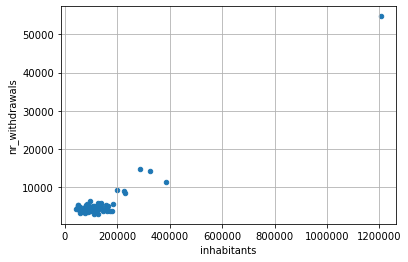

In [14]:
df_merged.plot(x ='inhabitants', y='nr_withdrawals', kind = 'scatter', grid = True)

But if we remove the 7 rows with the most inhabitants, the picture changes completely.

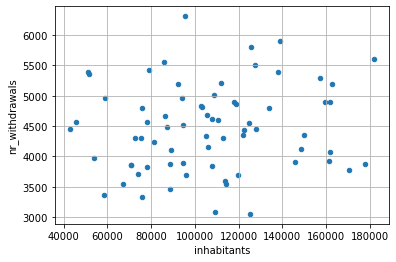

In [15]:
df_merged[7:].plot(x ='inhabitants', y='nr_withdrawals', kind = 'scatter', grid = True)

No linear relationship can be seen and the pearson correlation coefficient drops to 0.11. I therefore go with the Spearman rank coefficient, which gives a value of 0.35 for the whole dataset. So both variables are vagualy positively correlated (as expected).

In [16]:
df_merged[['nr_withdrawals','inhabitants']].corr(method='spearman')

,nr_withdrawals,inhabitants
nr_withdrawals,1.000000,0.347339
inhabitants,0.347339,1.000000


### Question 3
Visualize the average loan amount per district.

In [4]:
df_loan.head()

,loan_id,account_id,date,amount,duration,payments,status
0,4959,2,1994-01-05,80952,24,3373.0,A
1,4961,19,1996-04-29,30276,12,2523.0,B
2,4962,25,1997-12-08,30276,12,2523.0,A
3,4967,37,1998-10-14,318480,60,5308.0,D
4,4968,38,1998-04-19,110736,48,2307.0,C


In [19]:
df_avg_loan = pd.read_sql('''SELECT account.district_id AS district_id, 
            AVG(loan.amount) AS avg_loan
            FROM loan
            LEFT JOIN account ON loan.account_id = account.account_id
            GROUP BY district_id
            ORDER BY district_id''', conn)
df_avg_loan.head()

,district_id,avg_loan
0,1,153957.285714
1,2,147992.000000
2,3,243466.000000
3,4,158074.285714
4,5,190116.000000


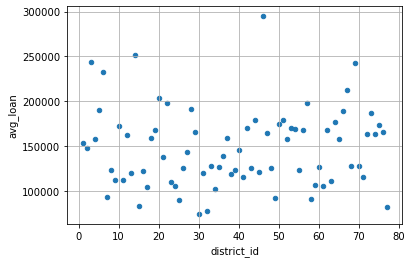

In [20]:
df_avg_loan.plot(x ='district_id', y='avg_loan', kind = 'scatter', grid = True)

The distribution of average loans is quite homogeneous and there is mainly just one outlier (district_id = 46). Especially compared to the districts close by. So this should be watched.

### Question 4
Build an ML model that classifies if a certain loan will be paid or not. You can use any classification model you think is suitable (hint: there are also some out of the box available in MLlib). Note that the goal is not to get the accuracy as high as possible – it is completely OK to choose a simple model and not spend days on parameter tuning. Think about questions like:

- a) Which model do you choose and why?
- b) How do you do the training and how do you measure the model accuracy?
- c) Which are the variables contributing the most to the prediction?
- d) How accurate does your model get?
- e) If you think a higher accuracy is possible, what would be the next steps you take?

I want to put together a small dataset, which I think could indicate if a loan gets paid or not. In the loan table I want to keep most as it is, exept I just keep the year of the date the loan was granted and throw away the loan_id.

In [21]:
# keep just year of the loan opening
df_loan['loan_year'] = df_loan.date.str.split(pat = "-", expand=True)[0].apply(int)

We want to check if the loan will be paid or not. This is a binary classification. So 'status' in 'df_loan' is our target variable and contains four classifications

- loan paid back in the past
- loan paid back in the present
- loan not paid back in the past
- loan not paid back in the present

To know if a loan will be paid back I classifiy the first two as 1 and the last two as 0

In [22]:
# encode status
df_loan.status = df_loan.status.map({'A': 1, 'B': 0,'C': 1, 'D': 0}) # 1=paid, 0=not paid
df_loan.drop(['loan_id','date'], axis=1, inplace=True)

In [23]:
df_loan.head()

,account_id,amount,duration,payments,status,loan_year
0,2,80952,24,3373.0,1,1994
1,19,30276,12,2523.0,0,1996
2,25,30276,12,2523.0,1,1997
3,37,318480,60,5308.0,0,1998
4,38,110736,48,2307.0,1,1998


df_client has properties of a client, which could tell, if he pays back his loan

In [24]:
df_client.head()

,client_id,gender,birth_date,district_id
0,1,F,1970-12-13,18
1,2,M,1945-02-04,1
2,3,F,1940-10-09,1
3,4,M,1956-12-01,5
4,5,F,1960-07-03,5


First I want to have the birth year

In [25]:
df_client['birth_year'] = df_client.birth_date.str.split(pat = "-", expand=True)[0].apply(int)

Next I want to encode gender and district ID

In [26]:
df_client_new = pd.concat([df_client, pd.get_dummies(df_client['gender'], prefix='gender')], axis=1)
df_client_new = pd.concat([df_client_new, pd.get_dummies(df_client['district_id'], prefix='D')], axis=1)
df_client_new.drop(['gender','birth_date','district_id'], axis=1, inplace = True)
df_client_new.head()


,client_id,birth_year,gender_F,gender_M,D_1,D_2,D_3,D_4,D_5,D_6,...,D_68,D_69,D_70,D_71,D_72,D_73,D_74,D_75,D_76,D_77
0,1,1970,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,1945,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,1940,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,1956,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,5,1960,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


And combine df_loan and df_client with the help of df_disp

In [27]:
df_final =pd.merge(df_loan, df_disp, on='account_id', how='left')
df_final =pd.merge(df_final, df_client_new, on='client_id', how='left')

In [28]:
df_final.drop(['disp_id','type', 'client_id', 'account_id'], axis=1, inplace=True) # delete features of df_disp
df_final.head()

,amount,duration,payments,status,loan_year,birth_year,gender_F,gender_M,D_1,D_2,...,D_68,D_69,D_70,D_71,D_72,D_73,D_74,D_75,D_76,D_77
0,80952,24,3373.0,1,1994,1945,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,80952,24,3373.0,1,1994,1940,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,30276,12,2523.0,0,1996,1939,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,30276,12,2523.0,1,1997,1962,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
4,318480,60,5308.0,0,1998,1952,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
# split dependent and independent variables
df_features = df_final.drop(['status'], axis=1)
df_outcome = df_final['status']
df_outcome.head()

0    1
1    1
2    0
3    1
4    0
Name: status, dtype: int64

I use Adaboost Classifier with the default weak learner Decision Tree Classifier, which is suitable for binary classification. AdaBoost classifier is a boosting classifier, which builds a strong classifier by combining multiple poorly performing classifiers to get a strong classifier.

In [30]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler

In [31]:
# scale data to reduce dominant influence of large features
scaler = MinMaxScaler()
df_features[df_features.columns] = scaler.fit_transform(df_features[df_features.columns])
df_features.head() # fast check how the data looks like

,amount,duration,payments,loan_year,birth_year,gender_F,gender_M,D_1,D_2,D_3,...,D_68,D_69,D_70,D_71,D_72,D_73,D_74,D_75,D_76,D_77
0,0.129680,0.25,0.319488,0.2,0.215686,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.129680,0.25,0.319488,0.2,0.117647,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.043179,0.00,0.231001,0.6,0.098039,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.043179,0.00,0.231001,0.8,0.549020,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.535129,1.00,0.520924,1.0,0.352941,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
# create the train and test data
X_train, X_test, y_train, y_test = train_test_split(df_features, df_outcome, test_size=0.2, random_state=42)

In [33]:
# Create adaboost classifer object
abc = AdaBoostClassifier(n_estimators=500, learning_rate=1)
# Train Adaboost Classifer
model = abc.fit(X_train, y_train)
#Predict the response for test dataset
y_pred = model.predict(X_test)

In [34]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.891566265060241


An easy way to measure the quality of a classification is the accuracy the model has. So 89% sounds good. But lets look at the distribution of paid and not-paid loans.

The ratio of loans paid back is 0.91 while the ratio of the loans not paid back is 0.09.


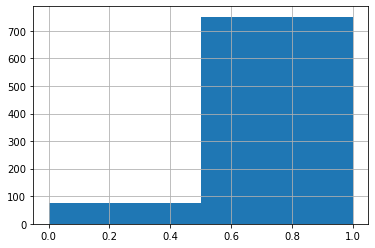

In [35]:
df_final['status'].hist(bins=2)
paid = df_final[df_final['status']==1].shape[0] # paid loans in the past and now
not_paid = df_final[df_final['status']==0].shape[0] # not paid loans in the past and now
total = df_final.shape[0] # loans count
print('The ratio of loans paid back is {:.2f} while the ratio of the loans not paid back is {:.2f}.'
     .format(paid/total, not_paid/total))

So by calling all loans "paid-back", I would have an accuracy of 91%, better than the Adaboost model! Of course this "model" is nonsense, but this is what you get, when the distribution is far from being equal. The F1 score (harmonic mean of precision and recall) is a better metric here.

In [36]:
print("F1 score:",metrics.f1_score(y_test, y_pred))

F1 score: 0.9415584415584416


The F1 score is 0.94 - surprisingly high - for the Adaboost model, while it would be 0 for my "all-loans-are-paid-back" model. So the F1 score is a much better metric to score the model.

Now lets see which features contribute the most to the classification

In [38]:
model.feature_importances_

array([0.32 , 0.004, 0.336, 0.024, 0.166, 0.004, 0.002, 0.006, 0.   ,
       0.002, 0.004, 0.   , 0.   , 0.   , 0.006, 0.002, 0.002, 0.   ,
       0.002, 0.002, 0.002, 0.   , 0.002, 0.002, 0.002, 0.002, 0.002,
       0.002, 0.002, 0.002, 0.004, 0.   , 0.   , 0.002, 0.002, 0.002,
       0.002, 0.002, 0.002, 0.   , 0.002, 0.   , 0.002, 0.002, 0.002,
       0.004, 0.002, 0.002, 0.   , 0.002, 0.   , 0.002, 0.002, 0.002,
       0.002, 0.   , 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.   ,
       0.002, 0.002, 0.002, 0.004, 0.002, 0.002, 0.002, 0.004, 0.   ,
       0.002, 0.004, 0.   , 0.002, 0.   , 0.   , 0.002, 0.008, 0.002,
       0.002, 0.002, 0.002])

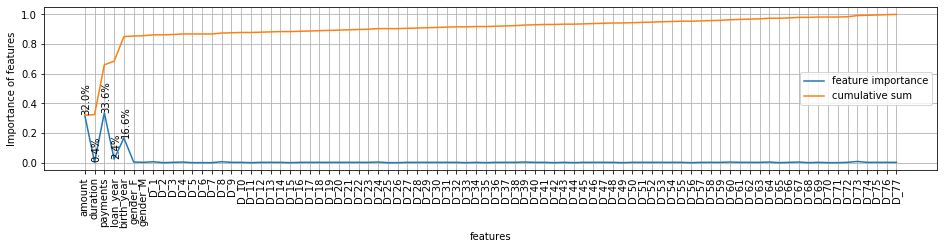

In [58]:
plt.figure(figsize=(16,3))
plt.plot(model.feature_importances_, label='feature importance')
plt.plot(np.cumsum(model.feature_importances_), label='cumulative sum')
plt.xticks(np.arange(df_features.shape[1]), df_features.columns.tolist(), rotation=90);
plt.grid();
for i in range(5):
    plt.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=10, rotation=90)
plt.legend();
plt.xlabel('features');
plt.ylabel('Importance of features');

So mostly two features in the "loan" table and one feature in the "client" table contribute to the prediction

- Payments with 34%
- loan amount with 32%
- birth year with 17% (but the year when the loan was granted only 2.4%)

The rest is below 5%. Surprisingly gender seems to have no influence, as doesn't the district.

To improve the model I would take the following steps:

- eliminate features which seem to have no influence (<1%)
- add potential data like account balance at the time the loan was granted or even the derivative of balance
- optimise parameters and split data into train, tests and validation sets to prevent overfitting in the optimisation process
- try another model, if F1 score not sufficient

### Question 5
Imagine that you are invited to go to a bank on-site and all they ask you is: “We have this data set above lying around. Could you do something with it that brings us some value?”

Can you think of a use case you could build that gets the bank excited? You do not need to implement something for this question, it is enough to describe your idea. Questions to guide your description:

- a) What’s your idea about?
- b) How would do implement it (technologies, algorithms, additional data, …)?
- c) What is the value for the bank (maybe that value could be even measured with some metric)?

If your idea is something bigger which needs too much text to explain in detail, try to limit your description to the most important points and explain the rest in the call with us. (If it is helpful, you can also include a drawing.)

So the goal is to create some value for the bank out of the data. There are different types of value like money, customer satisfaction or brand value.

My ideas are about marketing and sales. The first idea would be to substitute products the client uses with products of the bank. The bank knows a lot about their clients. They know how much money they earn per month and what they are spending it for, especially with electronic (card) payments. A bank often has own products like funds or sometimes insurances, which it could sell to suitable customers. So lets take take insurances as an example.

- have a database with entries for each insurance company, the different insurances they sell and their prices (this may need to be done manually)
- for each client collect information of his insurances: to which insurance company he transfers money (check if the recipient is one of the insurance companies in your database, what the amount is, what is the insurance for (this could be gathered from the transaction description or the amount per period).
- from this information the bank could arrange a insurance package, which fits the customer needs out of one hand and hopefully for a competitive price.

A second, and bigger idea would be to accompany your clients through out their lives with products and information they could need in their current phase of their lives. Age is of course the major parameter here and once kids get older their lifes diversify. Teenagers in a "Lehre" have other needs compared to students (pension). People in their twenties and thirties who start buying in kids stores not around holidays may get children. They then may look for a flat or house to buy and so on. So this is a classification problem is based on age. For all ages there is a list of possible targets like (student, employee, student with job, and so on). New recipients of money or a new employer could be a trigger for a new classification. This new classification is based on the old one, so convolutional neuronal networks could be suitable for that. For each of the classification the bank can offer the client informations, offers, or product suggestions. This should benefit the client first and keep him bonded with his bank and in the best case he would purchase some services from the bank, which otherwise he would not.